In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import pandas as pd
train_prompts = pd.read_csv('/content/drive/MyDrive/dataset/train_prompts.csv')
train_essays = pd.read_csv('/content/drive/MyDrive/dataset/train_essays.csv')
test_essays = pd.read_csv('/content/drive/MyDrive/dataset/test_essays.csv')
df_train_extra = pd.read_csv('/content/drive/MyDrive/dataset/train_v4_drcat_01.csv')

Text(0.5, 1.0, 'Distribution of prompt ID')

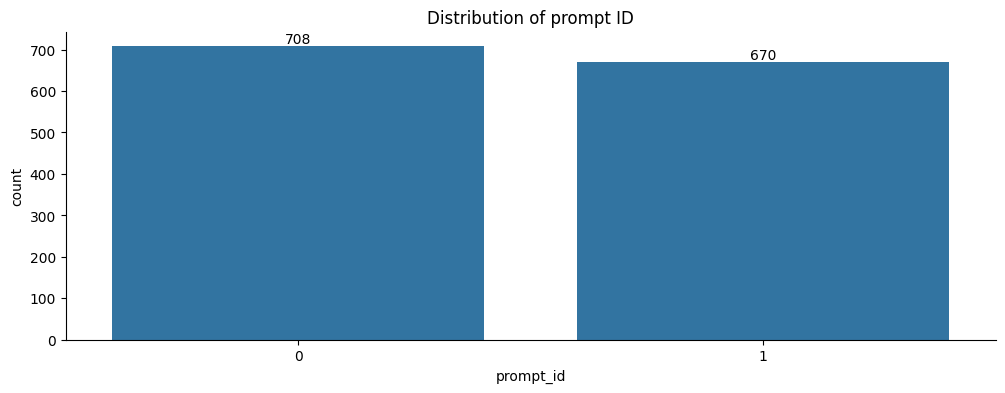

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
f, ax = plt.subplots(figsize=(12, 4))

sns.despine()
ax = sns.countplot(data=train_essays,
                   x="prompt_id")

abs_values = train_essays['prompt_id'].value_counts().values

ax.bar_label(container=ax.containers[0], labels=abs_values)

ax.set_title("Distribution of prompt ID")

Text(0.5, 1.0, 'Distribution of Generated Text')

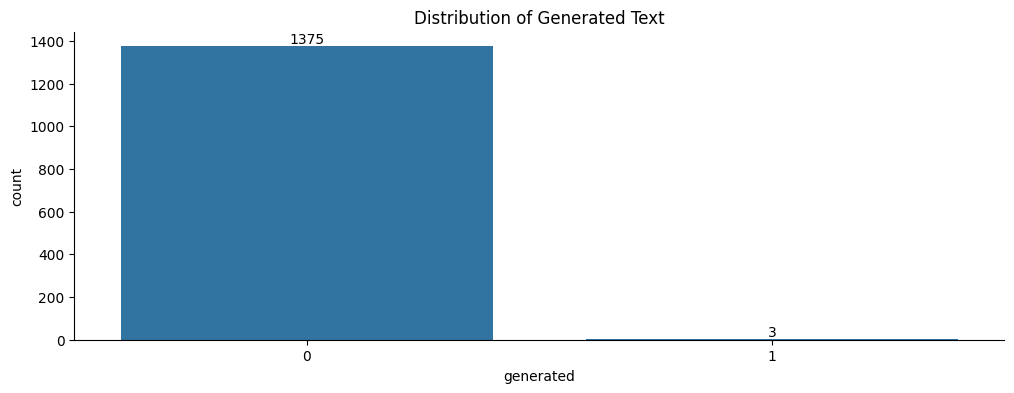

In [4]:
f, ax = plt.subplots(figsize=(12, 4))

sns.despine()
ax = sns.countplot(data=train_essays,
                   x="generated")

abs_values = train_essays['generated'].value_counts().values

ax.bar_label(container=ax.containers[0], labels=abs_values)

ax.set_title("Distribution of Generated Text")

In [5]:

df_train_extra.head()

,text,label,prompt_name,source,RDizzl3_seven,model
0,Phones\n\nModern humans today are always on th...,0,Phones and driving,persuade_corpus,False,human
1,This essay will explain if drivers should or s...,0,Phones and driving,persuade_corpus,False,human
2,Driving while the use of cellular devices\n\nT...,0,Phones and driving,persuade_corpus,False,human
3,Phones & Driving\n\nDrivers should not be able...,0,Phones and driving,persuade_corpus,False,human
4,Cell Phone Operation While Driving\n\nThe abil...,0,Phones and driving,persuade_corpus,False,human


In [6]:
df_train_extra.rename(columns = {"label":"generated"}, inplace=True)

In [7]:
df_train_essays_final = pd.concat([df_train_extra[["text", "generated"]], train_essays[["text", "generated"]]])

df_train_essays_final.info()

<class 'pandas.core.frame.DataFrame'>
Index: 74951 entries, 0 to 1377
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   text       74951 non-null  object
 1   generated  74951 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 1.7+ MB


In [8]:
df_train_essays_final.isna().sum()

text         0
generated    0
dtype: int64

In [9]:
df_train_essays_final.dropna(inplace=True)


Text(0.5, 1.0, 'Distribution of Generated Text')

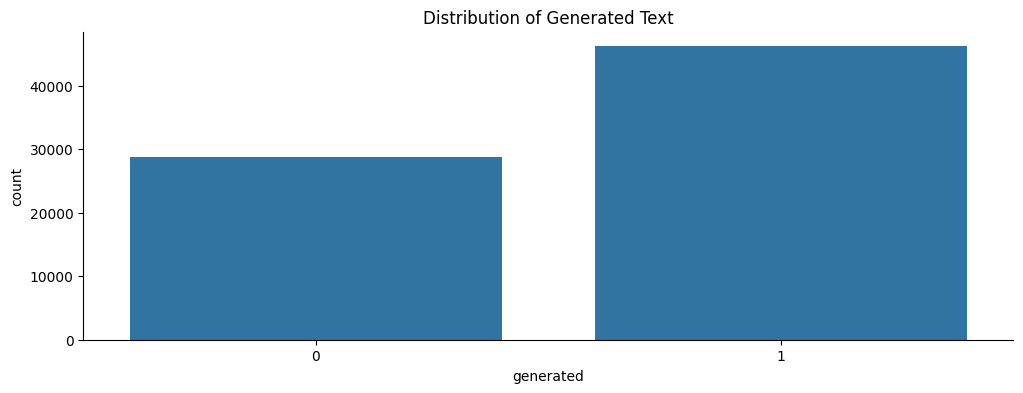

In [10]:
f, ax = plt.subplots(figsize=(12, 4))

sns.despine()
ax = sns.countplot(data=df_train_essays_final,
                   x="generated")

abs_values = df_train_essays_final['generated'].value_counts().values
ax.set_title("Distribution of Generated Text")

In [11]:
#importing necessary libraries
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras import layers, models
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

In [13]:
import re
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('punkt')
def normalize(text):
    # Replace with whitespace to separate '😃\n\nFor'
    text = text.replace(r"\n", r" ")
    text = text.replace(r"\r", r" ")
    # Drop puntuation
    text = re.sub(r'[^\w\s]', '', text)
    # Remove extra spaces from '😃  For' to '😃 For'
    text = re.sub(r"\s+", r" ", text)
    # Remove URLs
    text = re.sub(r'http\S+', '', text)
    # Remove leading and trailing whitespace
    text = text.strip()
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    #lower case the all capital alphabets
    text=text.lower()
    stop_words = set(stopwords.words('english'))
    word_tokens=word_tokenize(text)
    text = ' '.join([word for word in word_tokens if word not in stop_words])
    return text
from tqdm import tqdm
tqdm.pandas()
df_train_essays_final['text'] = df_train_essays_final['text'].progress_apply(lambda x: normalize(x))
test_essays['text'] = test_essays['text'].progress_apply(lambda x: normalize(x))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
100%|██████████| 3/3 [00:00<00:00, 1261.57it/s]


In [14]:
import torch
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from transformers import BertModel, BertTokenizer
from tqdm import tqdm  # Import tqdm for the progress bar

In [15]:
# Check if CUDA is available and set the device accordingly
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [16]:
from transformers import DistilBertModel, DistilBertTokenizer
from tqdm import tqdm
import torch

# Initialize the DistilBERT tokenizer and model
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
bert_model = DistilBertModel.from_pretrained('distilbert-base-uncased')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [17]:
# Set device to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
bert_model = bert_model.to(device)


In [18]:
# Enable mixed precision via torch.cuda.amp
from torch.cuda.amp import autocast
def encode_texts_in_batches(texts, tokenizer, model, batch_size=32, max_length=128):
    model.eval()  # Put the model in evaluation mode
    batched_features = []

    for i in tqdm(range(0, len(texts), batch_size), desc="Encoding texts in batches"):
        batch_texts = texts[i:i + batch_size]
        encoded = tokenizer(batch_texts, padding=True, truncation=True, max_length=max_length, return_tensors='pt').to(device)

        with torch.no_grad():
            # Mixed precision context
            with autocast(enabled=True):
                outputs = model(**encoded)
            batched_features.append(outputs.last_hidden_state[:, 0, :].cpu())

    return torch.cat(batched_features, dim=0).numpy()

In [19]:
# Encode text data
X = encode_texts_in_batches(df_train_essays_final['text'].to_list(), tokenizer, bert_model)
y = df_train_essays_final['generated'].values

Encoding texts in batches: 100%|██████████| 2343/2343 [07:04<00:00,  5.52it/s]


In [ ]:
# Since SVM in scikit-learn does not support GPU, ensure data is on CPU
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

# Train SVM
svm_classifier = SVC(probability=True, max_iter=1000)
svm_classifier.fit(X_train, y_train)

# Evaluate SVM
y_pred = svm_classifier.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
y_pred_proba = svm_classifier.predict_proba(X_test)[:, 1]  # Assuming 1 is the positive class
print(f"Accuracy: {accuracy}")

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_auc_score, log_loss, matthews_corrcoef
import joblib

model_metrics = {
    'accuracy': accuracy_score(y_test, y_pred),
    'precision': precision_score(y_test, y_pred),
    'recall': recall_score(y_test, y_pred),
    'f1': f1_score(y_test, y_pred),
    'roc_auc': roc_auc_score(y_test, y_pred_proba),
    'log_loss': log_loss(y_test, y_pred_proba),
    'mcc': matthews_corrcoef(y_test, y_pred)
}

# Print the computed metrics
for metric, value in model_metrics.items():
    print(f"{metric}: {value}")

# Save the metrics and probabilities
joblib.dump(model_metrics, '/content/drive/MyDrive/dataset/modelbert_metrics.pkl')
joblib.dump(y_pred_proba, '/content/drive/MyDrive/dataset/modelbert_y_pred_proba.pkl')

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_curve, auc, precision_recall_curve

# Assuming you have `y_test`, `y_pred`, and `y_pred_proba` available from your model's output

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show()

# ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
pr_auc = auc(recall, precision)

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='blue', lw=2, label=f'PR curve (area = {pr_auc:.2f})')
plt.fill_between(recall, precision, alpha=0.2, color='blue')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower left")
plt.show()
